# ✨ MLOps Zoom Camp W2

In [26]:
# importing libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error
import pickle

In [5]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='file:///E:/MLOPS/MLOPS/mlruns/2', creation_time=1685299479573, experiment_id='2', last_update_time=1685299479573, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [6]:

# reading Parquet file and getting the duration
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)
        df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)    
    return df

In [7]:
df = read_dataframe('./data/yellow_tripdata_2022-01.parquet')
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,N,142,236,1,14.50,3.0,0.5,3.65,0.0,0.3,21.95,2.5,0.0
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,N,236,42,1,8.00,0.5,0.5,4.00,0.0,0.3,13.30,0.0,0.0
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,N,166,166,1,7.50,0.5,0.5,1.76,0.0,0.3,10.56,0.0,0.0
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,N,114,68,2,8.00,0.5,0.5,0.00,0.0,0.3,11.80,2.5,0.0
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.30,1.0,N,68,163,1,23.50,0.5,0.5,3.00,0.0,0.3,30.30,2.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2463926,2,2022-01-31 23:36:53,2022-01-31 23:42:51,NaN,1.32,NaN,None,90,170,0,8.00,0.0,0.5,2.39,0.0,0.3,13.69,NaN,NaN
2463927,2,2022-01-31 23:44:22,2022-01-31 23:55:01,NaN,4.19,NaN,None,107,75,0,16.80,0.0,0.5,4.35,0.0,0.3,24.45,NaN,NaN
2463928,2,2022-01-31 23:39:00,2022-01-31 23:50:00,NaN,2.10,NaN,None,113,246,0,11.22,0.0,0.5,2.00,0.0,0.3,16.52,NaN,NaN
2463929,2,2022-01-31 23:36:42,2022-01-31 23:48:45,NaN,2.92,NaN,None,148,164,0,12.40,0.0,0.5,0.00,0.0,0.3,15.70,NaN,NaN


In [8]:
# getting duration column
df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
df.duration.std()

46.44530513776802

In [9]:
 df_new = df[(df.duration >= 1) & (df.duration <= 60)]

In [10]:
fraction_records = df_new.shape[0] / df.shape[0]

In [11]:
fraction_records

0.9827547930522406

In [12]:
df = df[(df.duration >= 1) & (df.duration <= 60)]
categorical = ['PULocationID', 'DOLocationID']
df[categorical] = df[categorical].astype(str)

train_dicts = df[categorical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts) # one hot encoding
target = 'duration'
y_train = df[target].values
X_train.shape

C:\Users\user\AppData\Local\Temp\ipykernel_10512\1695165724.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[categorical] = df[categorical].astype(str)


(2421440, 515)

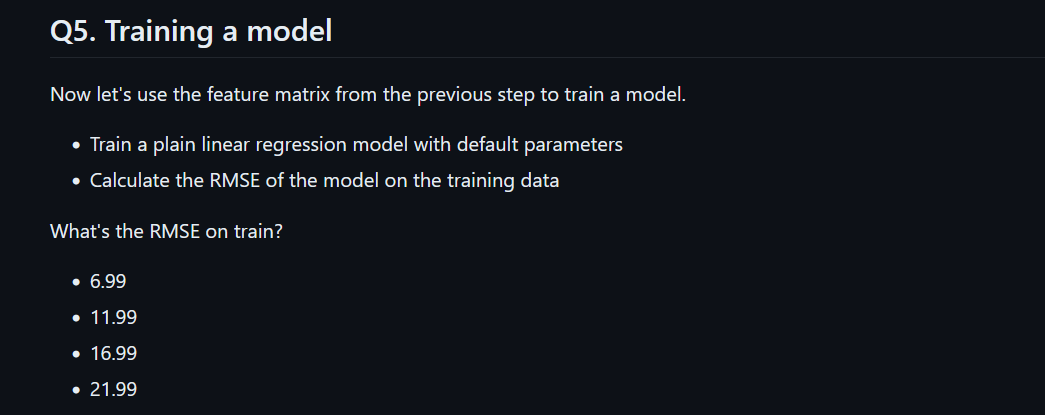

In [13]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

6.986190837370544

In [28]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [17]:
with mlflow.start_run():

    mlflow.set_tag("developer", "cristian")

    mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.csv")
    mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.csv")

    alpha = 0.1
    mlflow.log_param("alpha", alpha)
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

    mlflow.log_artifact(local_path="models/lin_reg.bin", artifact_path="models_pickle")

C:\Python311\Lib\site-packages\pickle4\__init__.py


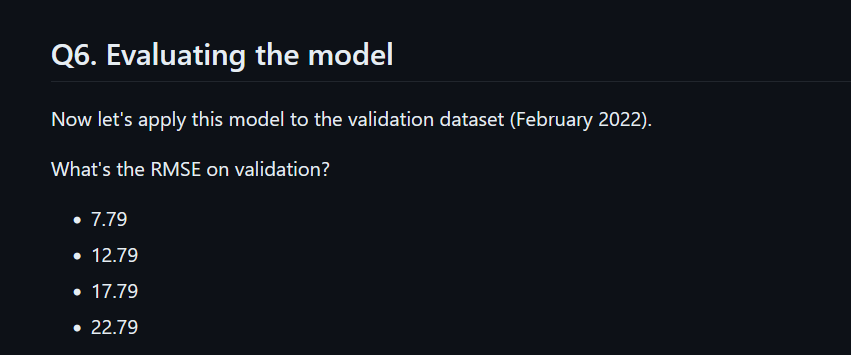

In [21]:
df_val = read_dataframe('./data/yellow_tripdata_2022-02.parquet')
df_val['duration'] = df_val.tpep_dropoff_datetime - df_val.tpep_pickup_datetime
df_val.duration = df_val.duration.apply(lambda td: td.total_seconds() / 60)
df_val = df_val[(df_val.duration >= 1) & (df_val.duration <= 60)]
categorical = ['PULocationID', 'DOLocationID']
df_val[categorical] = df_val[categorical].astype(str)

val_dicts = df_val[categorical].to_dict(orient='records')

X_val = dv.transform(val_dicts) # one hot encoding
target = 'duration'
y_val = df_val[target].values
X_val.shape

(2918187, 515)

In [22]:
y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.786409085078911